Nasa Space Apps Challenge 2025 Hackathan

A World Away: Hunting for Exoplanets with AI

Notebook 1 (1 of 2) 

The dataset that is used to train the following models included in these notebooks comes from observations made by "NASA Kepler Space Telescope" and downloaded using "Kepler labelled time-series dataset on Kaggle". Each row represents a star’s flux measurements, with a label indicating whether a planet is present. The train dataset contains 5087 rows (Observations) and 3198 columns (features). Column 1 is the label vector and from columns 2 to 3198 are the flux values over time. There are 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars in the train dataset. The challenge is to build a model that can identify exoplanets using their light curves. 

This notebook contains the exploration of dataset, testing the feasibility of training a CNN model, switching to MLP models, training two MLP models (baseline model and a oversampled model), evaluating the model using confusion matrix and other metrics and ploting the light curves of random instances.

In [11]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import random

This code cell loads and preprocesses the training data set

In [12]:
data = pd.read_csv("exoTrain.csv")
data["LABEL"] = data["LABEL"].map({1:0, 2:1})
print(data["LABEL"].value_counts())

LABEL
0    5050
1      37
Name: count, dtype: int64


This code cell trains a simple 1D CNN (Trained for 2 epochs). However, due to the complexness of this approach, I then switched to MLP model due to time restrictions. 

In [13]:
# This class creates a custom data set to load data 
class KeplerDataset(Dataset):
    def __init__(self, df):
        self.X = df.drop("LABEL", axis=1).values.astype(np.float32)
        self.y = df["LABEL"].values.astype(np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = KeplerDataset(data)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# This class defines a simple 1D CNN model 
class ExoTorchNet(nn.Module):
    def __init__(self):
        super(ExoTorchNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(16 * ((3197-4)//2), 2)

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model = ExoTorchNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# This loop trains the model for 2 epochs
for epoch in range(2): 
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 80.4243
Epoch 2, Loss: 22.9818


This code cell is just for the debugging purpose of previous CNN model

In [14]:
print("Dataset shape:", data.shape)
print("Label counts:", data["LABEL"].value_counts())

Dataset shape: (5087, 3198)
Label counts: LABEL
0    5050
1      37
Name: count, dtype: int64


The following code cell trains and evaluates the models. I have trained two models due to the imbalance nature of the data set.
1. Baseline model - This uses the normal shuffle
2. Oversampled Model - This uses the weighted sampler to mitigate the imbalance nature of the data set


Train label counts:
LABEL
0    4292
1      31
Name: count, dtype: int64
Val label counts:
LABEL
0    758
1      6
Name: count, dtype: int64

======= Training baseline model =======
Epoch 1/10, Train Acc: 0.9130
Epoch 2/10, Train Acc: 0.8545
Epoch 3/10, Train Acc: 0.7988
Epoch 4/10, Train Acc: 0.7881
Epoch 5/10, Train Acc: 0.8755
Epoch 6/10, Train Acc: 0.9130
Epoch 7/10, Train Acc: 0.8725
Epoch 8/10, Train Acc: 0.9190
Epoch 9/10, Train Acc: 0.7897
Epoch 10/10, Train Acc: 0.8543

======= Training oversampled model =======
Epoch 1/10, Train Acc: 0.5938
Epoch 2/10, Train Acc: 0.6789
Epoch 3/10, Train Acc: 0.6986
Epoch 4/10, Train Acc: 0.7675
Epoch 5/10, Train Acc: 0.7957
Epoch 6/10, Train Acc: 0.7881
Epoch 7/10, Train Acc: 0.7303
Epoch 8/10, Train Acc: 0.7997
Epoch 9/10, Train Acc: 0.7828
Epoch 10/10, Train Acc: 0.8344


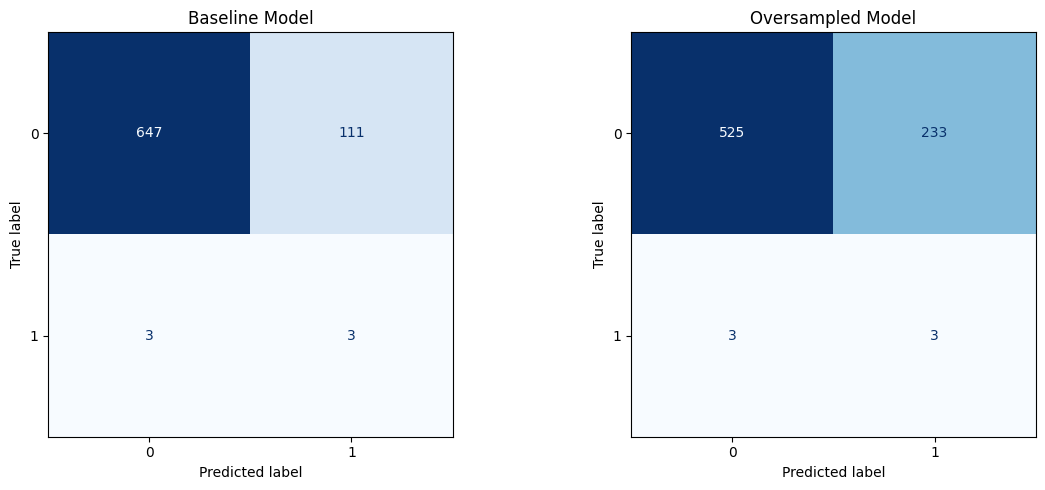


======= Baseline Model Metrics =======
              precision    recall  f1-score   support

           0     0.9954    0.8536    0.9190       758
           1     0.0263    0.5000    0.0500         6

    accuracy                         0.8508       764
   macro avg     0.5109    0.6768    0.4845       764
weighted avg     0.9878    0.8508    0.9122       764


======= Oversampled Model Metrics =======
              precision    recall  f1-score   support

           0     0.9943    0.6926    0.8165       758
           1     0.0127    0.5000    0.0248         6

    accuracy                         0.6911       764
   macro avg     0.5035    0.5963    0.4206       764
weighted avg     0.9866    0.6911    0.8103       764



In [15]:
# This splits the train data into train and validation sets
train_df, val_df = train_test_split(data, test_size=0.15, stratify=data["LABEL"], random_state=42)
print("\nTrain label counts:")
print(train_df["LABEL"].value_counts())
print("Val label counts:")
print(val_df["LABEL"].value_counts())

# This class creates a custom data set to load data
class KeplerDataset(Dataset):
    def __init__(self, df):
        X = df.drop("LABEL", axis=1).values.astype(np.float32)
        y = df["LABEL"].values.astype(np.int64)
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx], dtype=torch.long)

# This class defines a simple MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

# This function trains the model and evaluates the model
def train_model(train_loader, val_loader, input_size, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_size).to(device)

    # This pays more attention to rare class
    class_counts = train_df["LABEL"].value_counts().sort_index()
    weights = torch.tensor([1.0/class_counts[0], 1.0/class_counts[1]], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        running_correct, running_total = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            running_correct += (preds == y_batch).sum().item()
            running_total += X_batch.size(0)

        acc = running_correct / running_total
        print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {acc:.4f}")

    # This evaluates the model using validation data set
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            out = model(Xv)
            all_preds.extend(out.argmax(dim=1).cpu().numpy())
            all_labels.extend(yv.cpu().numpy())

    return model, np.array(all_labels), np.array(all_preds)

# This prepares data loaders
input_size = train_df.drop("LABEL", axis=1).shape[1]
batch_size = 64

train_ds = KeplerDataset(train_df)
val_ds = KeplerDataset(val_df)

# This is baseline model
train_loader_baseline = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# This is oversampled model
class_sample_counts = train_df["LABEL"].value_counts().to_dict()
weights = [1.0 / class_sample_counts[label] for label in train_df["LABEL"]]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
train_loader_oversample = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)

# This trains baseline and oversampled model
print("\n======= Training baseline model =======")
baseline_model, labels_base, preds_base = train_model(train_loader_baseline, val_loader, input_size)

print("\n======= Training oversampled model =======")
oversample_model, labels_over, preds_over = train_model(train_loader_oversample, val_loader, input_size)

# This plots confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_base = confusion_matrix(labels_base, preds_base)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=[0, 1])
disp1.plot(ax=axes[0], cmap="Blues", values_format="d", colorbar=False)
axes[0].set_title("Baseline Model")

cm_over = confusion_matrix(labels_over, preds_over)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_over, display_labels=[0, 1])
disp2.plot(ax=axes[1], cmap="Blues", values_format="d", colorbar=False)
axes[1].set_title("Oversampled Model")

plt.tight_layout()
plt.show()

# This displays metrics of models
print("\n======= Baseline Model Metrics =======")
print(classification_report(labels_base, preds_base, digits=4))

print("\n======= Oversampled Model Metrics =======")
print(classification_report(labels_over, preds_over, digits=4))


This code cell loads and preprocesses the test data set

In [16]:
test_df = pd.read_csv("exoTest.csv")
test_df["LABEL"] = test_df["LABEL"].map({1: 0, 2: 1})

This code cell is just to get an idea about the data set

In [17]:

print("Test dataset shape:", test_df.shape)
print("Label distribution:\n", test_df["LABEL"].value_counts())

Test dataset shape: (570, 3198)
Label distribution:
 LABEL
0    565
1      5
Name: count, dtype: int64


This code cell prepares the test data set to load into PyTorch and evaulate the test data set as well. This uses the previously used oversampled model. Finally it displays the metrics of the outcomes of the model.


=== Test Set Report (Oversampled Model) ===
               precision    recall  f1-score   support

No Planet (0)      0.991     0.773     0.869       565
   Planet (1)      0.008     0.200     0.015         5

     accuracy                          0.768       570
    macro avg      0.499     0.487     0.442       570
 weighted avg      0.982     0.768     0.861       570



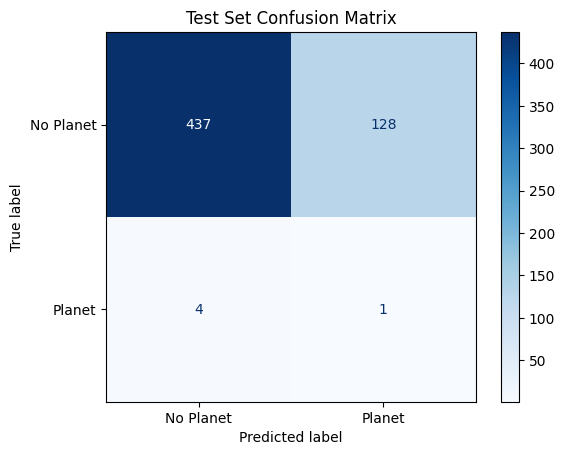

In [18]:
# This prepares the data set to be loaded
test_ds = KeplerDataset(test_df)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This evaluates the over sampled model
oversample_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        out = oversample_model(X)
        preds = out.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# This displays the metrics of the outcomes of the model
print("\n=== Test Set Report (Oversampled Model) ===")
print(classification_report(all_labels, all_preds, target_names=["No Planet (0)", "Planet (1)"], digits=3))

# This plots the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Planet", "Planet"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Test Set Confusion Matrix")
plt.show()

This code displays the light curves of randomly selected 6 instances. However, this is just to enhance the visual clarity of the trained model and not a part of the functional code to give a qualitative idea about the light curve. 

P.S: It uses the oversampled model to predict. Alternatively you can use the baseline model which is commented below and compare with light curve as well.

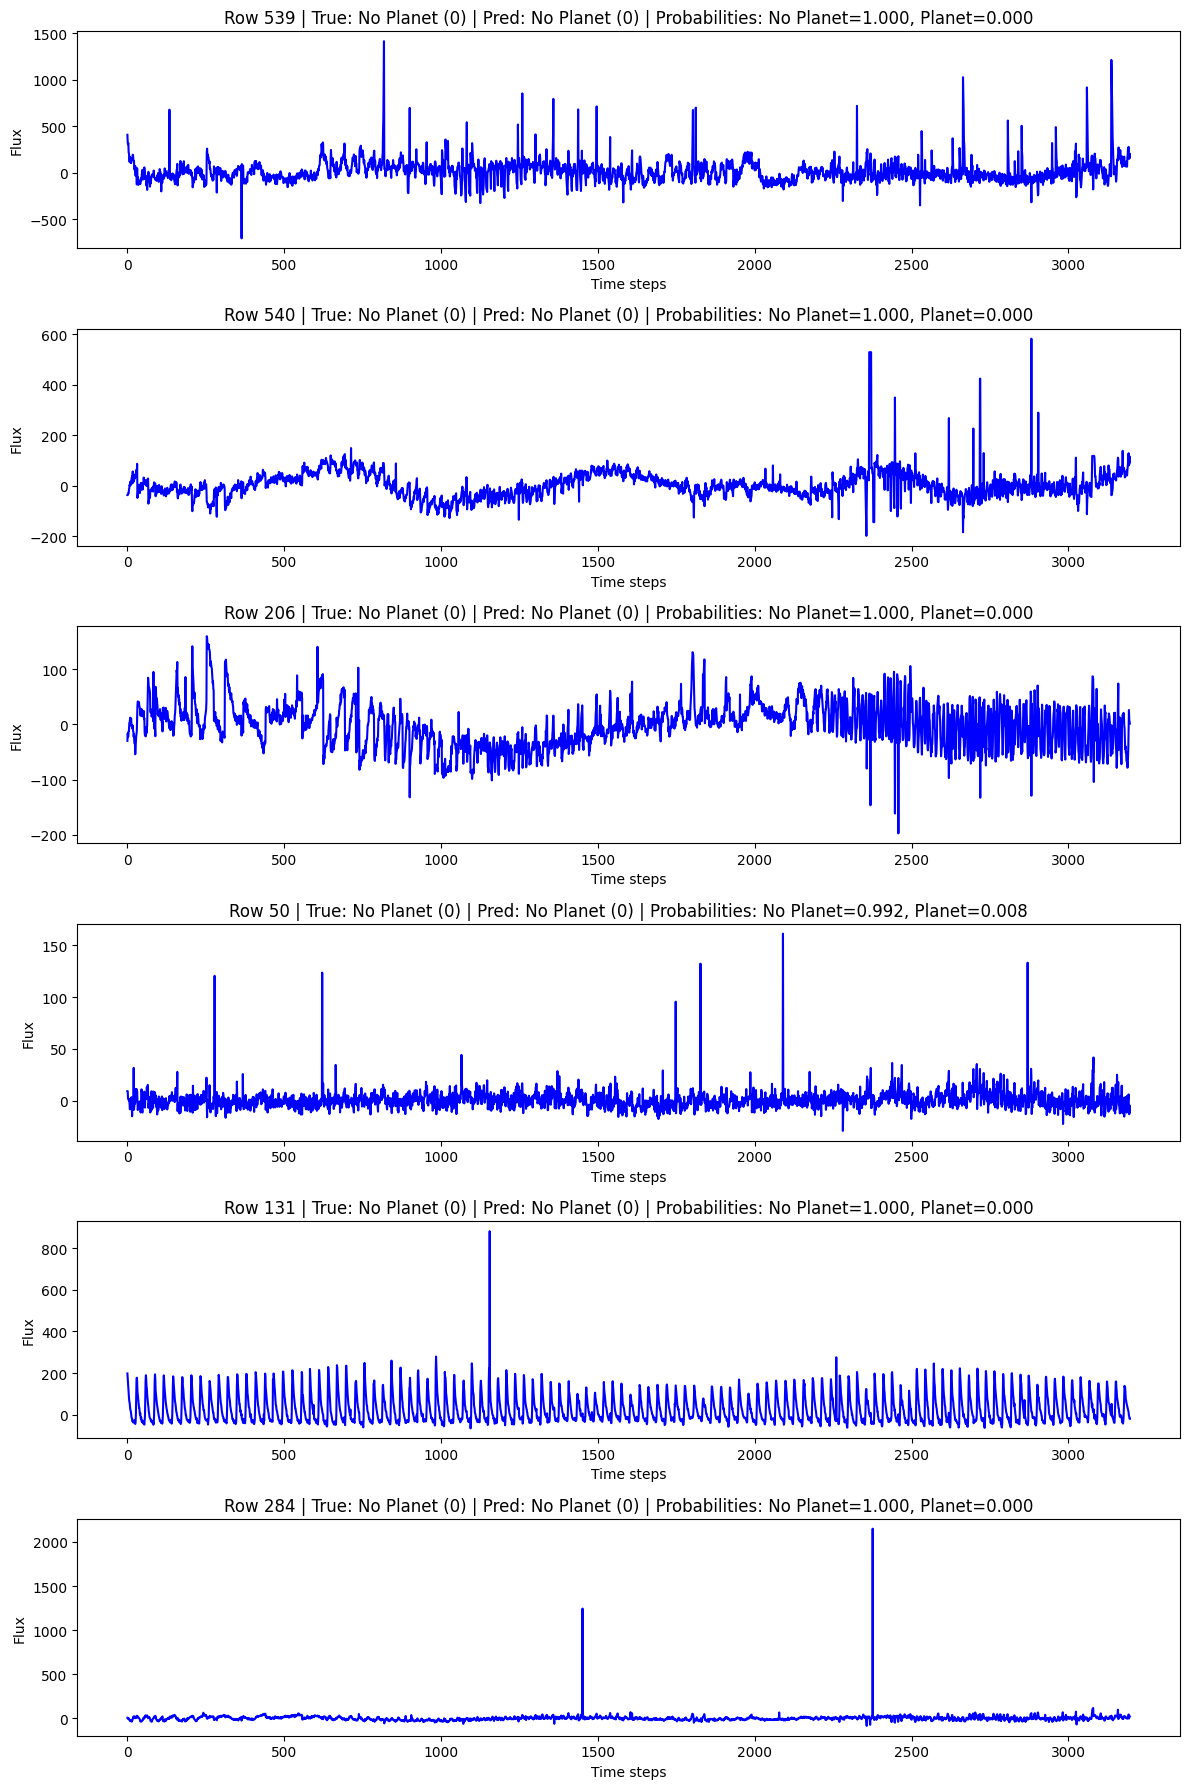

In [19]:
def plot_multiple_lightcurves(model, df, n=6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    labels = ["No Planet (0)", "Planet (1)"]
    
    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n))
    
    if n == 1:
        axes = [axes]
    
    for i in range(n):
        idx = random.randint(0, len(df)-1)
        row = df.iloc[idx]
        X = row.drop("LABEL").values.astype(np.float32)
        y_true = int(row["LABEL"])
        
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            out = model(X_tensor)
            probs = torch.softmax(out, dim=1).cpu().numpy().flatten()
        
        axes[i].plot(X, color="blue")
        axes[i].set_title(
            f"Row {idx} | True: {labels[y_true]} | Pred: {labels[np.argmax(probs)]} "
            f"| Probabilities: No Planet={probs[0]:.3f}, Planet={probs[1]:.3f}"
        )
        axes[i].set_xlabel("Time steps")
        axes[i].set_ylabel("Flux")
    
    plt.tight_layout()
    plt.show()

plot_multiple_lightcurves(oversample_model, test_df, n=6)
#plot_multiple_lightcurves(baseline_model, test_df, n=6)


This code cell saves the trained model to be used in web app

In [20]:
torch.save(oversample_model.state_dict(), "oversample_model.pth")